In [139]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import glob
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import collect_set,sum,avg,max,countDistinct,count
from pyspark.sql.functions import col,array_contains
from pyspark.sql.functions import when
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist

# Step 1 - Evaluate Phy Rates at Different RSSI levels

In [92]:
spark = SparkSession.builder.getOrCreate()

In [93]:
data_folder = r"C:\Users\MC127HM\OneDrive - EY\Desktop\Docs\Personal\Prodapt\Assignment\Dataset"
file_name = "*"
file_path = data_folder + "\\" + file_name

files = glob.glob(file_path)
dfs = []

for file in files:
    df = spark.read.csv(file, header=True)
    df = df.withColumnRenamed('_c0','sno')
    dfs.append(df)
    print((df.count(), len(df.columns)))


(350000, 30)
(350596, 30)


In [94]:
df_complete = reduce(DataFrame.unionAll, dfs)
print((df_complete.count(), len(df_complete.columns)))

(700596, 30)


In [96]:
df_complete = df_complete.withColumn("rssi_percs_25", df_complete["rssi_percs_25"].cast(IntegerType()))
df_complete = df_complete.withColumn("rssi_percs_75", df_complete["rssi_percs_75"].cast(IntegerType()))
df_complete = df_complete.withColumn("txWeightedPhyRate", df_complete["txWeightedPhyRate"].cast(IntegerType()))
df_complete = df_complete.withColumn("rxWeightedPhyRate", df_complete["rxWeightedPhyRate"].cast(IntegerType()))

In [97]:
df_complete.select('rssi_percs_25', 'rssi_percs_75', 'txWeightedPhyRate', 'rxWeightedPhyRate',).summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|     rssi_percs_25|     rssi_percs_75|txWeightedPhyRate| rxWeightedPhyRate|
+-------+------------------+------------------+-----------------+------------------+
|  count|            699924|            699924|           673879|            690727|
|   mean|-58.49826552597139|-56.93842331453129| 283.519769869665|258.50901586299653|
| stddev|12.741807234764162|12.510865179685881|268.8097414020819| 267.9553050297518|
|    min|               -95|               -95|                0|                 0|
|    25%|               -67|               -66|               72|                60|
|    50%|               -60|               -58|              144|               140|
|    75%|               -51|               -50|              431|               404|
|    max|                32|                32|             1300|              1300|
+-------+------------------+------------------+-----------------+

## Checking if there is any null values in the rssi and weighted phy columns and filling them with mean values

In [98]:
avg_rssi_percs_25 = df_complete.select(avg('rssi_percs_25')).collect()[0][0]
avg_rssi_percs_75 = df_complete.select(avg('rssi_percs_75')).collect()[0][0]
avg_txWeightedPhyRate = df_complete.select(avg('txWeightedPhyRate')).collect()[0][0]
avg_rxWeightedPhyRate = df_complete.select(avg('rxWeightedPhyRate')).collect()[0][0]


new_df = df_complete.na.fill({"rssi_percs_25":avg_rssi_percs_25, "rssi_percs_75": avg_rssi_percs_75, "txWeightedPhyRate":avg_txWeightedPhyRate, "rxWeightedPhyRate":avg_rxWeightedPhyRate})

In [99]:
pd_df_complete=df_complete.toPandas()

## Look at the RSSI levels (rssi_percs_25) and look at the spread of Tx and Rx weighted Phy Rate

<AxesSubplot:xlabel='rssi_percs_25'>

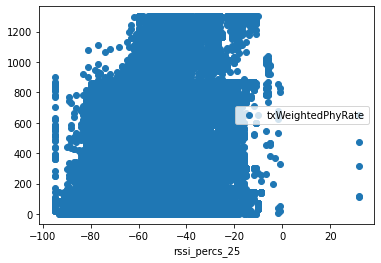

In [100]:
pd_df_complete.plot(x='rssi_percs_25', y='txWeightedPhyRate', style='o')

<AxesSubplot:xlabel='rssi_percs_25'>

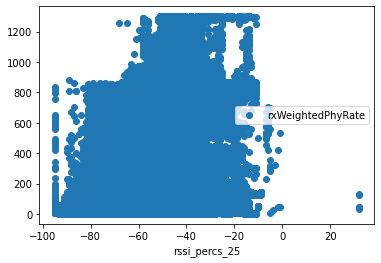

In [101]:
pd_df_complete.plot(x='rssi_percs_25', y='rxWeightedPhyRate', style='o')

## Produce a histogram (graph and CSV) for the average Tx and Rx Weighed Phy Rate between -85 and -65 dB in 1 dB steps

In [157]:
new_list = []

for i in range(-85,-64):
    new_dict = {}
    new_dict['rssi_percs_25'] = i
    new_dict['rxWeightedPhyRate'] = df_complete.filter(df_complete["rssi_percs_25"] == i).agg({"rxWeightedPhyRate":"avg"}).collect()[0][0]
    new_dict['txWeightedPhyRate'] = df_complete.filter(df_complete["rssi_percs_25"] == i).agg({"txWeightedPhyRate":"avg"}).collect()[0][0]
    
    new_list.append(new_dict)



In [145]:
histogram_df = pd.DataFrame(new_list)

### Histogram

Text(0, 0.5, 'Tx Weighted Phy Rate')

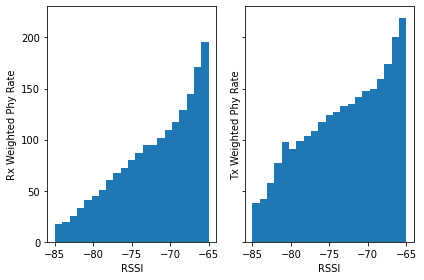

In [166]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(histogram_df.rssi_percs_25, weights=histogram_df.rxWeightedPhyRate, bins=21)
axs[0].set_xlabel("RSSI")
axs[0].set_ylabel("Rx Weighted Phy Rate")
axs[1].hist(histogram_df.rssi_percs_25, weights=histogram_df.txWeightedPhyRate, bins=21)
axs[1].set_xlabel("RSSI")
axs[1].set_ylabel("Tx Weighted Phy Rate")

### Genarated CSV

In [156]:
histogram_df.to_csv("histogram_data.csv", index=False)

# Step 2 - Evaluate RSSI threshold

### Using the client stats sample data provided to you calculate what % of devices are connected to 2.4 GHz and 5 GHz

In [78]:
total_count = new_df.count()

device_2_4 = new_df.filter(col("freq_band") == "2.4G").count()
device_2_4

device_5 = new_df.filter(col("freq_band") == "5G").count()
device_5

percent_2_4_device = round((device_2_4/total_count)*100,2)

percent_5_device = round((device_5/total_count)*100,2)

print("{0}% of devices are  connected to 2.4 GHz network".format(str(percent_2_4_device)))
print("{0}% of devices are  connected to 5 GHz network".format(str(percent_5_device)))

44.92% of devices are  connected to 2.4 GHz network
55.08% of devices are  connected to 5 GHz network


In [88]:
new_df = new_df.withColumn('freq_band', when((new_df.rssi_percs_25 >= -60) & (new_df.freq_band == "2.4G"), "5G")\
                  .when((new_df.rssi_percs_25 <= -75) & (new_df.freq_band == "5G"), "2.4G")\
                  .when((new_df.rssi_percs_25 > -75) & (new_df.freq_band == "5G"), "5G")\
                  .when((new_df.rssi_percs_25 < -60) & (new_df.freq_band == "2.4G"), "2.4G")\
                  .otherwise(new_df['freq_band']))

### % of devices that will be on 2.4GHz and 5GHz using Band Steering Feature

In [90]:
total_count_new = new_df.count()

device_2_4_new = new_df.filter(col("freq_band") == "2.4G").count()

device_5_new = new_df.filter(col("freq_band") == "5G").count()

percent_2_4_device_new = round((device_2_4_new/total_count_new)*100,2)

percent_5_device_new = round((device_5_new/total_count_new)*100,2)

print("{0}% of devices are  connected to 2.4 GHz network".format(str(percent_2_4_device_new)))
print("{0}% of devices are  connected to 5 GHz network".format(str(percent_5_device_new)))

29.65% of devices are  connected to 2.4 GHz network
70.35% of devices are  connected to 5 GHz network


### Using Band Steering Feature we will definetely gain more devices on 5G as shown above